#### 1. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2

In [2]:
from itertools import tee
from keras.utils import to_categorical

In [3]:
EPSILON = 1e-5
PUZZLE_PATCH = 64
PUZZLE_SIZE = 3
PUZZLE_DIM = PUZZLE_PATCH*PUZZLE_SIZE
PATCH_DIM = PUZZLE_DIM // PUZZLE_SIZE
CHANNELS = 3

#### 2. Loading all the files

In [4]:
mean_confidences = np.load('numpy/Ex2_COCO_confidences_mean.npy')
mode_predictions = np.load('numpy/Ex2_COCO_prediction_mode.npy')
labels = np.load('../../../dataset/COCO/Ex2_COCO_labels.npy')
selected_permutation = np.load("../permutation.npy")

In [5]:
images = np.load('../../../dataset/COCO/Ex2_COCO_image.npy')

In [6]:
jigsaw_images = np.load('../../../dataset/COCO/Ex2_COCO_jigsaw_images.npy')

In [7]:
categorical_accuracy = np.mean(mode_predictions == labels)
print("Categorical Accuracy:", categorical_accuracy)

Categorical Accuracy: 0.8353333333333334


In [8]:
mode_predictions_ohe = to_categorical(mode_predictions,num_classes=1000)
labels_ohe = to_categorical(labels,num_classes=1000)

In [9]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [10]:
def accuracy(y_true, y_pred):
    """
        Simple categorical accuracy.
    """
    return np.mean(y_true == y_pred)

In [11]:
def classifier_calibration_error(y_pred, y_true, y_confidences, metric="mae", num_bins=10, weighted=False):
    """
        Estimates calibration error for a classifier.
        y_pred are the class predictions of the model (integers), while y_true is the ground truth labels (integers),
        and y_confidences are confidences for each prediction (in the [0, 1] range).
        All three arrays must have equal number of samples.
    """

    bin_edges = np.linspace(0.0, 1.0 + EPSILON, num_bins + 1)

    errors = []
    weights = []

    for start, end in pairwise(bin_edges):
        indices = np.where(np.logical_and(y_confidences >= start, y_confidences < end))
        filt_preds = y_pred[indices]
        filt_classes = y_true[indices]
        filt_confs = y_confidences[indices]

        if len(filt_confs) > 0:
            bin_acc = accuracy(filt_classes, filt_preds)
            bin_conf = np.mean(filt_confs)

            error = abs(bin_conf - bin_acc)
            weight = len(filt_confs)

            errors.append(error)            
            weights.append(weight)

    errors = np.array(errors)
    weights = np.array(weights) / sum(weights)

    if weighted:
        return sum(errors * weights)

    return np.mean(errors)

In [12]:
error = classifier_calibration_error(mode_predictions_ohe,labels_ohe,mean_confidences)
print("classifier calibration error is",error)

classifier calibration error is 0.3418101970825505


## Classifier calibration Curve

In [13]:
def classifier_calibration_curve(y_pred, y_true, y_confidences, metric="mae", num_bins=10):
    """
        Estimates the calibration plot for a classifier and returns the points in the plot.
        y_pred are the class predictions of the model (integers), while y_true is the ground truth labels (integers),
        and y_confidences are confidences for each prediction (in the [0, 1] range).
        All three arrays must have equal number of samples.
    """

    bin_edges = np.linspace(0.0, 1.0 + EPSILON, num_bins + 1)
    curve_conf = []
    curve_acc = []

    for start, end in pairwise(bin_edges):
        indices = np.where(np.logical_and(y_confidences >= start, y_confidences < end))
        filt_preds = y_pred[indices]
        filt_classes = y_true[indices]
        filt_confs = y_confidences[indices]

        if len(filt_confs) > 0:
            bin_acc = accuracy(filt_classes, filt_preds)
            bin_conf = np.mean(filt_confs)

            curve_conf.append(bin_conf)
            curve_acc.append(bin_acc)
        else:
            p = np.mean([start, end])
            curve_conf.append(p)
            curve_acc.append(p)

    return curve_conf, curve_acc

In [14]:
curve_confidences, curve_accuracy = classifier_calibration_curve(mode_predictions_ohe,labels_ohe,mean_confidences)

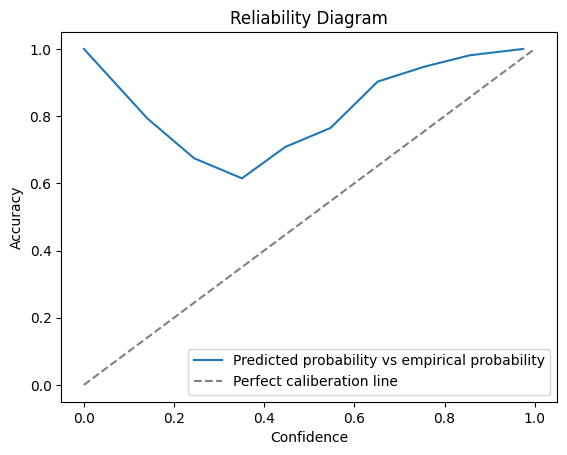

In [15]:
plt.plot(curve_confidences, curve_accuracy, label=f"label {labels}")   
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
c = ["Predicted probability vs empirical probability","Perfect caliberation line"]
plt.legend(c)
plt.title('Reliability Diagram')
plt.show()

## Classifier accuracy confidence curve

In [16]:
def classifier_accuracy_confidence_curve(y_pred, y_true, y_confidences, num_points=20):
    candidate_confs = np.linspace(0.0, 0.99, num=num_points)

    out_confidences = []
    out_accuracy = []

    for confidence in candidate_confs:
        examples_idx = np.where(y_confidences >= confidence)
        filt_preds = y_pred[examples_idx]
        filt_true = y_true[examples_idx]

        acc = accuracy(filt_true, filt_preds)

        out_confidences.append(confidence)
        out_accuracy.append(acc)

    return out_confidences, out_accuracy

In [17]:
 output_confidences, output_accuracy = classifier_accuracy_confidence_curve(mode_predictions_ohe,labels_ohe,mean_confidences)

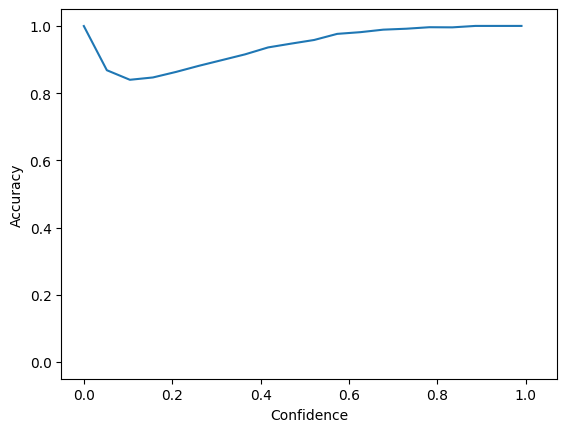

In [18]:
plt.plot( output_confidences, output_accuracy, label=f"label {labels}")    
plt.plot([0, 1.02], [0, 1], alpha =0.0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.show()

#### Train Result

In [19]:
def plot_results(jigsaw, output, image):
    w = 15
    h = 15
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = 1
    for i in range(1, rows*columns, columns):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.title('Jigsaw puzzle')
        plt.imshow(jigsaw)
    
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title('Solved jigsaw puzzle')
        plt.imshow(output)
        
        fig.add_subplot(rows, columns, i+2)
        plt.axis('off')
        plt.title('Original Image')
        plt.imshow(image)
        plt.show()

In [20]:
def output_assemble_image(jigsaw_image,predicted_label):
    k=0
    tiles = [None] * 9
    for i in range(PUZZLE_SIZE*PUZZLE_SIZE):
        tiles[selected_permutation[predicted_label][k]] = jigsaw_image[i,:,:,:]
        k=k+1
    combined_image_jigsaw = np.zeros((PUZZLE_DIM,PUZZLE_DIM,CHANNELS))
    for i in range(PUZZLE_SIZE):
        for j in range(PUZZLE_SIZE):
            patch = tiles[i*PUZZLE_SIZE+j]
            combined_image_jigsaw[i*PATCH_DIM:(i+1)*PATCH_DIM, j*PATCH_DIM:(j+1)*PATCH_DIM, :] = patch
    return (combined_image_jigsaw)

In [21]:
def jigsaw_image_assemble(image_jigsaw):
    combined_image_jigsaw = np.zeros((PUZZLE_DIM,PUZZLE_DIM,CHANNELS))
    for i in range(PUZZLE_SIZE):
        for j in range(PUZZLE_SIZE):
            patch = image_jigsaw[i*PUZZLE_SIZE+j]
            combined_image_jigsaw[i*PATCH_DIM:(i+1)*PATCH_DIM, j*PATCH_DIM:(j+1)*PATCH_DIM, :] = patch
    return (combined_image_jigsaw)

In [22]:
def numpy_entropy(probs, axis=-1, eps=1e-6):
    return -np.sum(probs * np.log(probs + eps), axis=axis)

In [23]:
entropy = numpy_entropy(mean_confidences, axis=-1, eps=1e-6)
top_indices = np.argsort(entropy)[-5:]
top_indices = list(reversed(top_indices))
bottom_indices = np.argsort(entropy)[:5]

In [24]:
print("Top 5 entropy are:")
for i in top_indices:
    print(entropy[i])

Top 5 entropy are:
6.4627795
6.2250347
5.6664286
5.467414
5.4244213


In [25]:
print("Bottom 5 entropy are:")
for i in bottom_indices:
    print(entropy[i])

Bottom 5 entropy are:
2.2148538e-06
1.8210356e-05
2.2674081e-05
4.2947242e-05
4.340971e-05


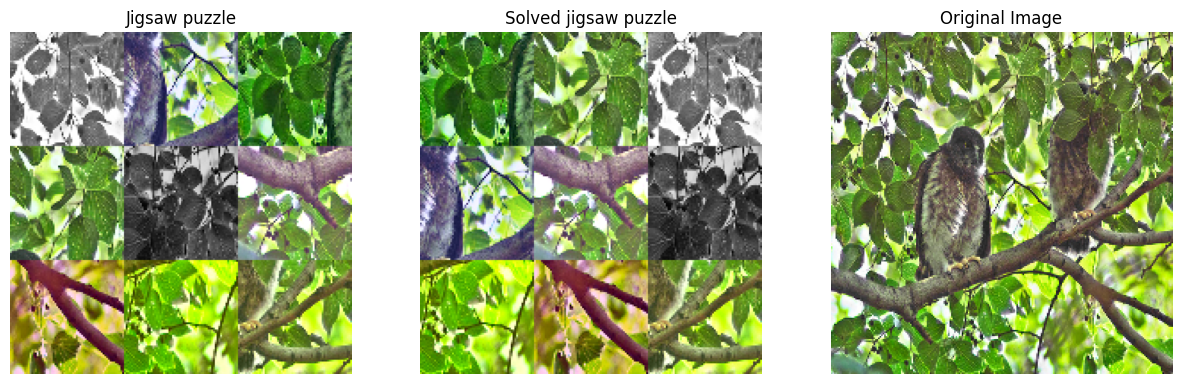

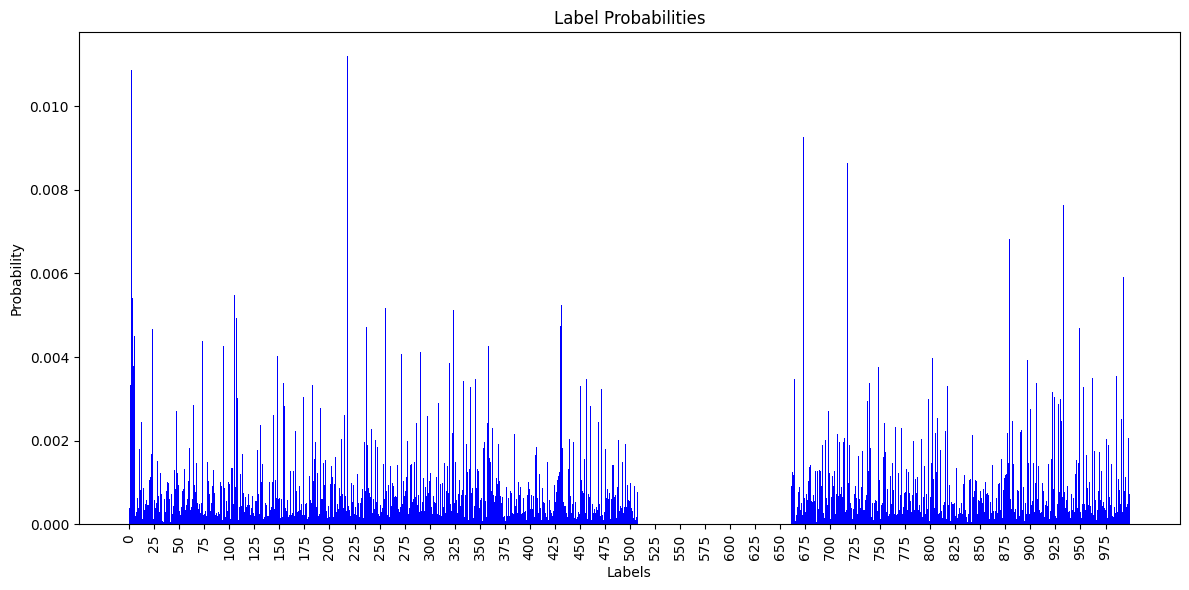

In [26]:
image = images[top_indices[0]]
jigsaw_image = jigsaw_images[top_indices[0],:,:,:,:]
label = labels[top_indices[0]]
prediction_label = mode_predictions[top_indices[0]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[top_indices[0]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()

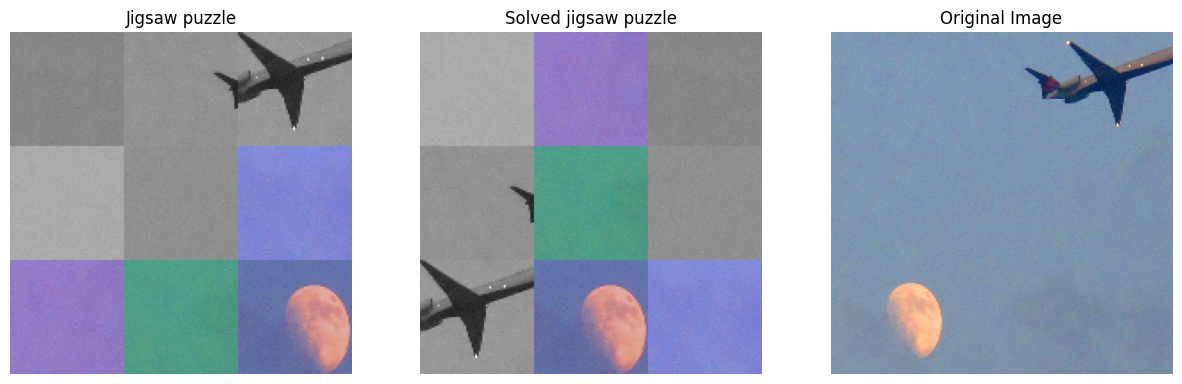

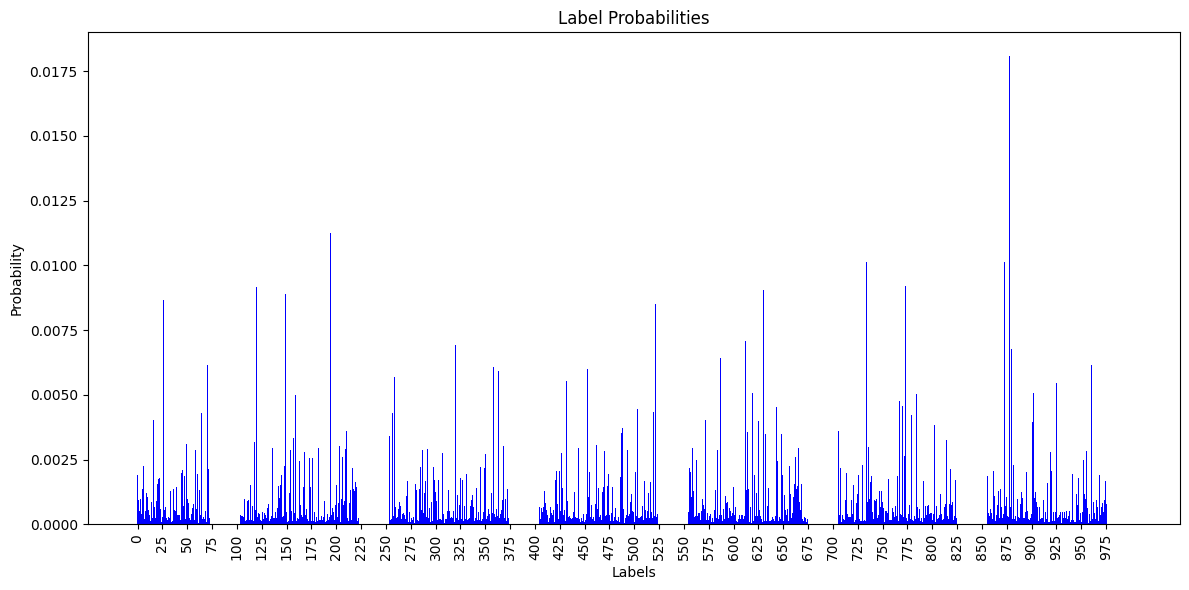

In [27]:
image = images[top_indices[1]]
jigsaw_image = jigsaw_images[top_indices[1],:,:,:,:]
label = labels[top_indices[1]]
prediction_label = mode_predictions[top_indices[1]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[top_indices[1]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()

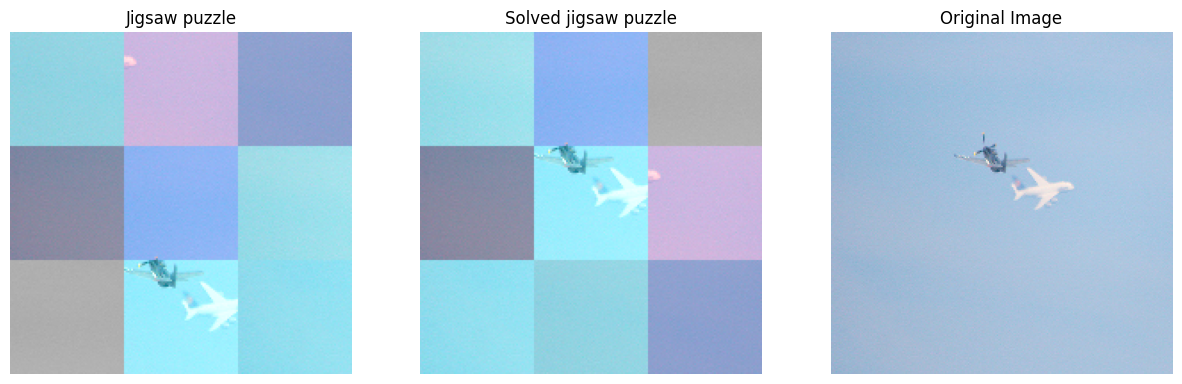

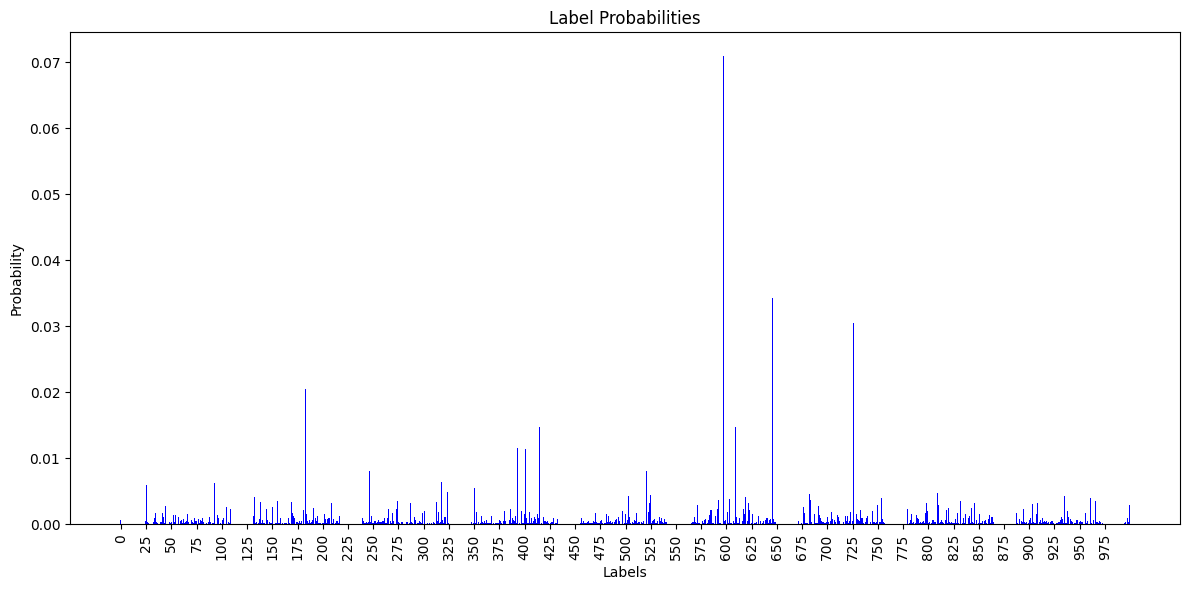

In [28]:
image = images[top_indices[2]]
jigsaw_image = jigsaw_images[top_indices[2],:,:,:,:]
label = labels[top_indices[2]]
prediction_label = mode_predictions[top_indices[2]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[top_indices[2]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()

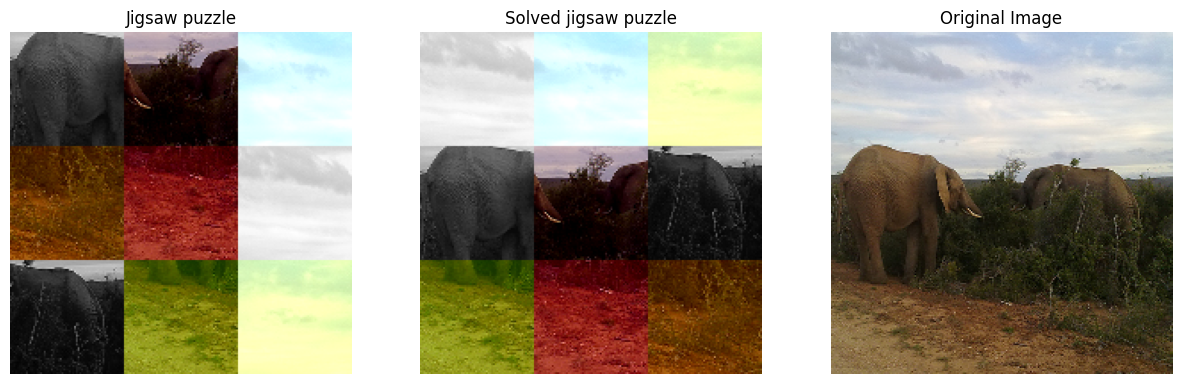

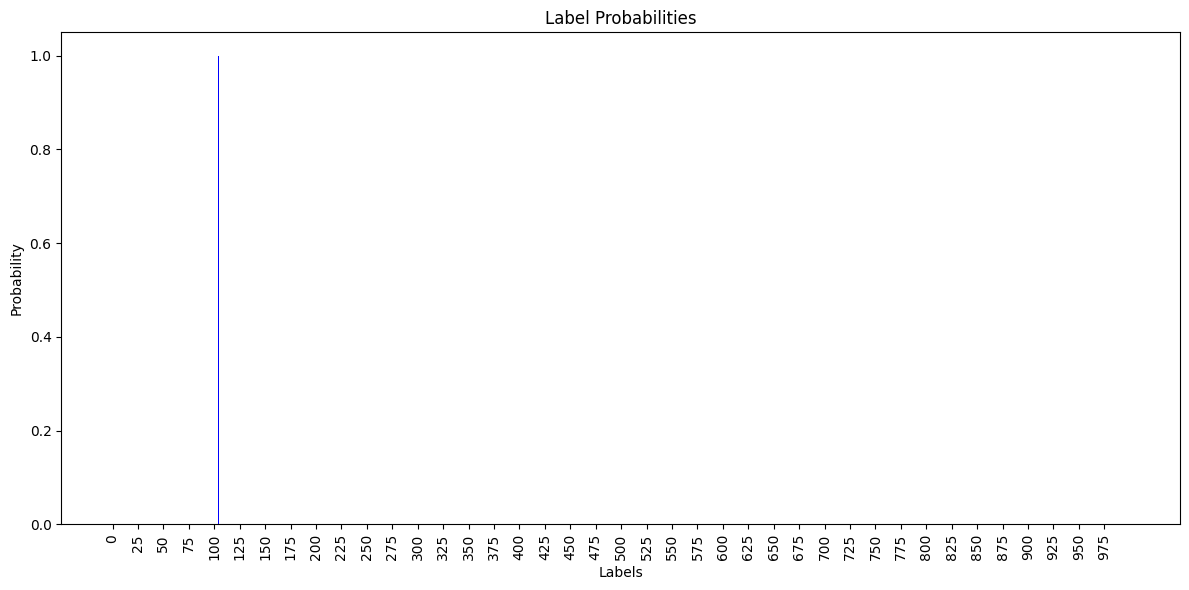

In [29]:
image = images[bottom_indices[0]]
jigsaw_image = jigsaw_images[bottom_indices[0],:,:,:,:]
label = labels[bottom_indices[0]]
prediction_label = mode_predictions[bottom_indices[0]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[bottom_indices[0]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()

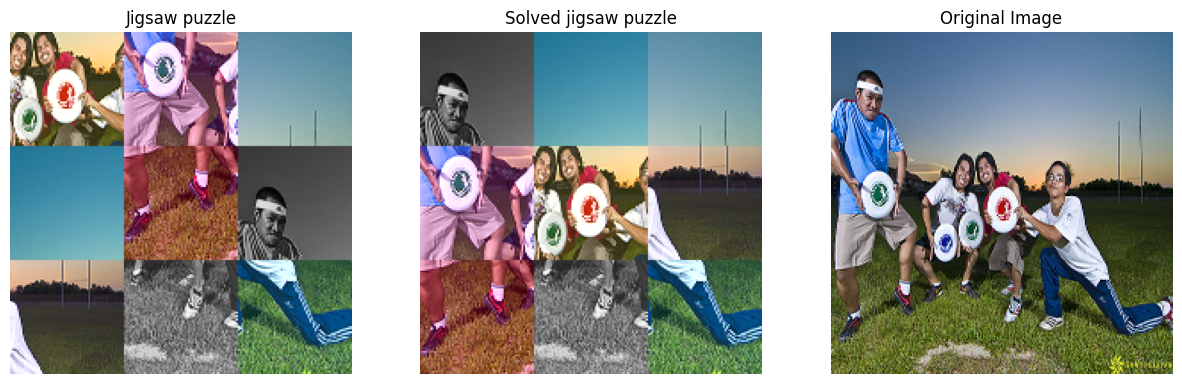

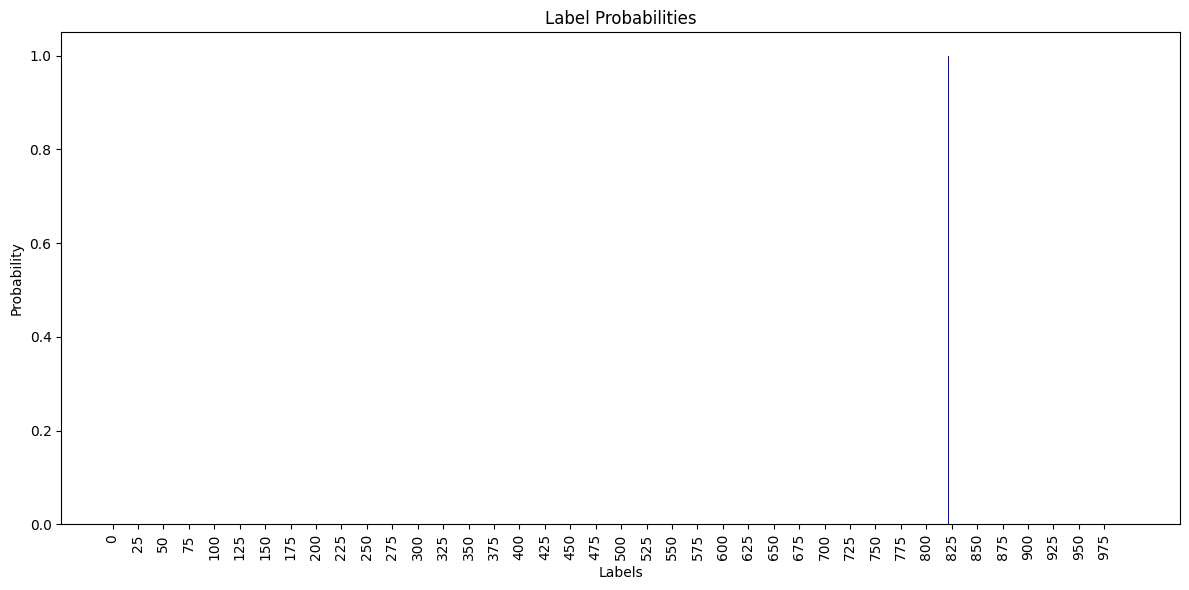

In [30]:
image = images[bottom_indices[1]]
jigsaw_image = jigsaw_images[bottom_indices[1],:,:,:,:]
label = labels[bottom_indices[1]]
prediction_label = mode_predictions[bottom_indices[1]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[bottom_indices[1]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()

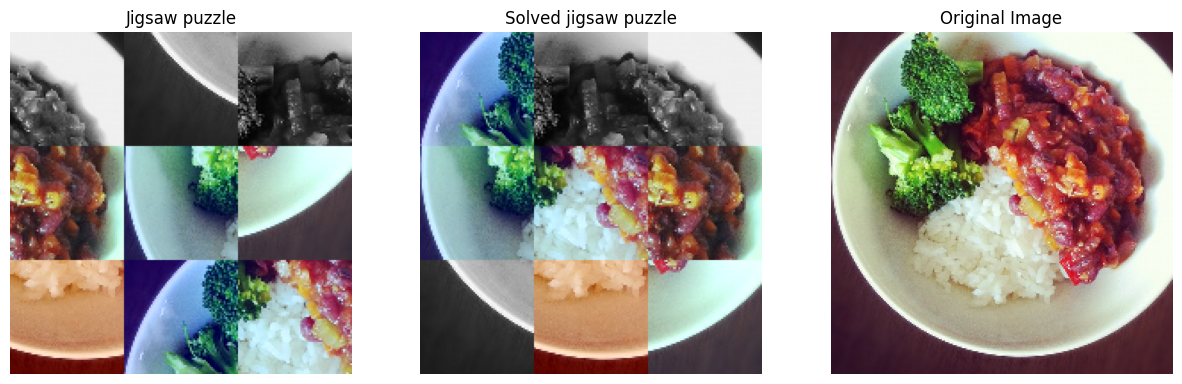

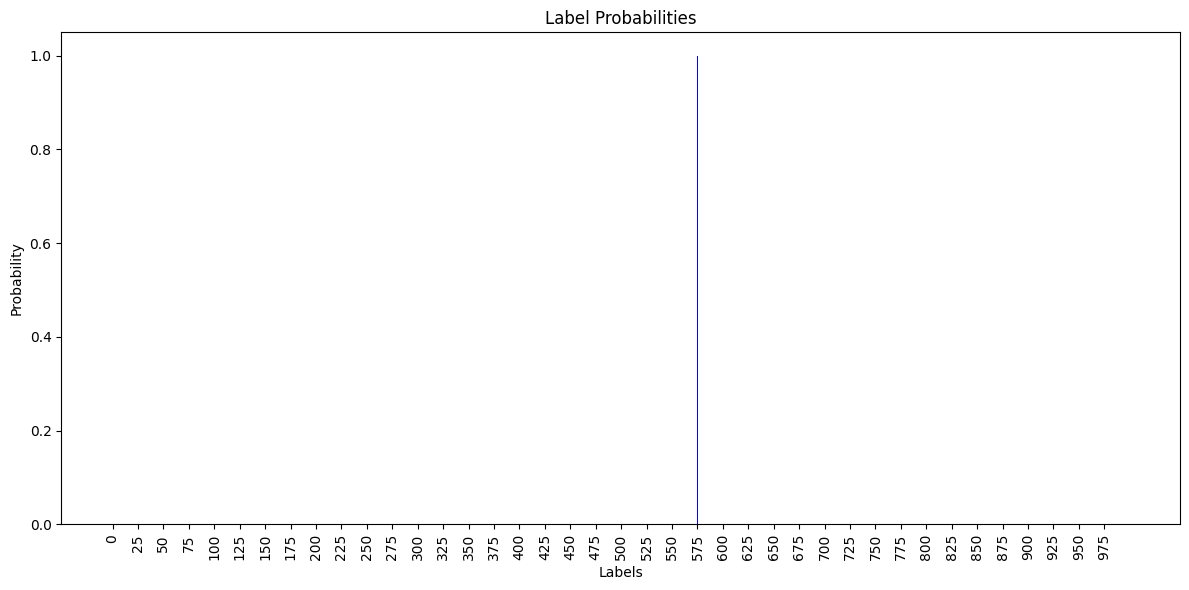

In [31]:
image = images[bottom_indices[2]]
jigsaw_image = jigsaw_images[bottom_indices[2],:,:,:,:]
label = labels[bottom_indices[0]]
prediction_label = mode_predictions[bottom_indices[2]]
jigsaw_image_assembly = jigsaw_image_assemble(jigsaw_image)
output_image = output_assemble_image(jigsaw_image,int(prediction_label))
plot_results(jigsaw_image_assembly, output_image, image)
probabilities = mean_confidences[bottom_indices[2]]
bar_labels = np.arange(0, 1000)
plt.figure(figsize=(12, 6))
plt.bar(bar_labels, probabilities, color='blue')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Label Probabilities')
plt.xticks(bar_labels[::25], bar_labels[::25], rotation=90)  # Display every 50th label
plt.tight_layout()
plt.show()